In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pcl
import matplotlib.cm as pcm

import itertools as it

In [2]:
def rand_numpy(size):
    return np.random.random(size)

def seed_numpy(seed):
    np.random.seed(seed)

rand = rand_numpy
seed = seed_numpy
# uncomment for determinism
#seed(42)

In [3]:
class MCRT:
    def __init__(self, n_packets, tau_max, use_nee=False, use_ffs=False):
        self.n_packets = n_packets
        self.tau_max = tau_max
        self.albedo = 1.0
        self.kappa = 0.01
        self.r_max = self.tau_max / self.kappa
        self.nee = use_nee
        self.ffs = use_ffs
        if use_nee:
            # (pos, weight) buffer for peeled off photons
            # size according to expected number of scatters
            exp_nscat = max(1, tau_max + tau_max**2 / 2)
            self.nee_max = int(exp_nscat) * n_packets
            self.nee_next = 0
            self.nee_photons = np.zeros((self.nee_max, 4))
        self.complete = np.zeros(self.n_packets, dtype=bool)
        self.incomplete = ~self.complete
        self.n_incomplete = self.n_packets
        assert self.incomplete.sum() == self.n_incomplete
        self.n_iter = 0

    def emit(self):
        """generate photon packets at origin with isotropic direction"""
        self.position = np.zeros((self.n_packets, 3))
        self.theta, self.phi = MCRT.random_iso_dir(self.n_packets)

    def move(self):
        """take step along random walks for all photon packets"""
        path_length = self.tau / self.tau_max * self.r_max # distance each packet travels
        dpos = np.array([path_length * np.cos(self.phi[self.incomplete]) * np.sin(self.theta[self.incomplete]),
                         path_length * np.sin(self.phi[self.incomplete]) * np.sin(self.theta[self.incomplete]),
                         path_length * np.cos(self.theta[self.incomplete])]).T # direction vector for each packet
        self.position[self.incomplete] += dpos

    def interact(self):
        """test photon packets for scattering, escape etc. and update weights appropriately"""
        i_incomplete, = np.nonzero(self.incomplete) # find indices of currently active packets
        escaped = np.einsum('ij,ij->i', self.position[i_incomplete], self.position[i_incomplete]) > \
            self.r_max * self.r_max # test active packets for escape condition
        i_escaped = i_incomplete[escaped]
        self.complete[i_escaped] = True # mark complete if packet left sphere this iteration
        
        # optimisation: albedo of one means packets are never absorbed
        if self.albedo < 1:
            absorbed = rand(self.n_incomplete) > self.albedo
            i_absorbed = i_incomplete[absorbed]
            self.complete[i_absorbed] = True # mark complete if absorbed this iteration
            scattered = ~(escaped | absorbed)
        else:
            scattered = ~escaped
        i_scattered = i_incomplete[scattered]
        
        # bookkeeping
        self.incomplete = ~self.complete
        self.n_incomplete -= i_escaped.size
        if self.albedo < 1:
            self.n_incomplete -= i_absorbed.size

        # calculate new directions for scattered packets
        newtheta, newphi = MCRT.random_iso_dir(self.n_incomplete)
        self.theta[i_scattered] = newtheta
        self.phi[i_scattered] = newphi

        if self.nee:
            n_scat = i_scattered.size
            # peel off one photon per scattering event
            # with weight set by the optical depth at which scattering occured
            weights = self.nee_weights(self.position[i_scattered]) * self.weights[i_scattered]
            # check if NEE photon buffer big enough
            if self.nee_next + n_scat > self.nee_max:
                self.nee_photons.resize(2 * self.nee_max, 4)
                self.nee_max *= 2
            # copy scattering positions, weights to buffer
            self.nee_photons[self.nee_next:self.nee_next+n_scat,0:3] = self.position[i_scattered]
            self.nee_photons[self.nee_next:self.nee_next+n_scat,3] = weights
            self.nee_next += n_scat

    def nee_weights(self, scattered_pos):
        """calculate NEE weights for scattered particles"""
        zs = np.sqrt(self.r_max**2 - scattered_pos[:,0]**2 - scattered_pos[:,1]**2) # z coordinates of cloud edge
        dists = np.abs(zs - scattered_pos[:,2]) # perpendicular distances to cloud edge
        taus = dists * self.kappa
        return np.exp(-taus) * (1 / (4 * np.pi)) # weight by tau and prob. for scattering in the observer direction

    def random_iso_dir(size):
        """choose theta, phi angles such that direction is uniformly chosen"""
        theta = np.arccos(2 * rand(size) - 1)
        phi = 2 * np.pi * rand(size)
        return theta, phi

    def run(self):
        """main loop"""
        print('tau={}'.format(self.tau_max))
        self.emit() # generate photons
        
        if self.ffs:
            self.weights = np.full(self.n_packets, 1 - np.exp(-self.tau_max)) # pre-weight for forced first scatter
        else:
            self.weights = np.ones(self.n_packets)
        
        while self.n_incomplete > 0:
            if self.n_iter == 0 and self.ffs:
                self.tau = -np.log(1 - rand(self.n_packets) * self.weights)
            else:
                self.tau = -np.log(rand(self.n_incomplete))

            self.move() # update positions
            self.interact() # handle absorptions, scatters etc

            self.n_iter += 1
            print('iteration {}, packets complete: {}/{}'.format(self.n_iter,
                                                                 self.n_packets - self.n_incomplete,
                                                                 self.n_packets), end='\r')
        print()

    def get_image(self):
        """transform photon packet coordinates to image plane along z axis"""
        if self.nee:
            #print(self.nee_next)
            self.position = np.append(self.position, self.nee_photons[:self.nee_next,:3], 0)
            self.weights = np.append(self.weights, self.nee_photons[:self.nee_next,3])
            self.theta = np.append(self.theta, 0.01 + np.zeros(self.nee_next))
            self.phi = np.append(self.phi, 0.01 + np.zeros(self.nee_next))

        ximg = (self.position[:,2] * np.sin(self.theta) -
                self.position[:,1] * np.cos(self.theta) * np.sin(self.phi) -
                self.position[:,0] * np.cos(self.theta) * np.cos(self.phi))
        yimg = (self.position[:,1] * np.cos(self.phi) -
                self.position[:,0] * np.sin(self.phi))

        # bin in cos(theta)
        costheta_bins = np.linspace(1.0, -1.0, 10)
        binned_theta = np.digitize(np.cos(self.theta), costheta_bins)
        # and in phi
        phi_bins = np.linspace(0.0, 2.0 * np.pi, 10)
        binned_phi = np.digitize(self.phi, phi_bins)
            
        # make image from (0,0) bins
        image_idxs = (binned_theta == 1) & (binned_phi == 1)
        self.weights[~image_idxs] = 0
            
        return ximg[image_idxs], yimg[image_idxs], self.weights[image_idxs]

In [4]:
#%load_ext line_profiler

Np = int(1e6)
tau_max = [0.01, 0.1, 1, 2, 5, 10]
mcrt_objs = [MCRT(Np, tm, use_ffs=False, use_nee=False) for tm in tau_max]
mcrt_objs_nee = [MCRT(Np, tm, use_ffs=True, use_nee=True) for tm in tau_max]
for model in it.chain(mcrt_objs, mcrt_objs_nee):
    #prof_stats = %lprun -r -f MCRT.interact model.run()
    model.run()

tau=0.01
iteration 5, packets complete: 1000000/1000000
tau=0.1
iteration 6, packets complete: 1000000/1000000
tau=1
iteration 21, packets complete: 1000000/1000000
tau=2
iteration 50, packets complete: 1000000/1000000
tau=5
iteration 157, packets complete: 1000000/1000000
tau=10
iteration 589, packets complete: 1000000/1000000
tau=0.01
iteration 5, packets complete: 1000000/1000000
tau=0.1
iteration 7, packets complete: 1000000/1000000
tau=1
iteration 22, packets complete: 1000000/1000000
tau=2
iteration 56, packets complete: 1000000/1000000
tau=5


KeyboardInterrupt: 

In [5]:
def plot_image(mcrt_objs):
    fig, axs = plt.subplots(ncols=len(tau_max)+1, figsize=(4*len(tau_max), 4), gridspec_kw={'width_ratios':[1]*len(tau_max)+[0.1]})
    cmap = pcm.get_cmap('gist_heat')
    cmap.set_bad('k')
    fig.suptitle(('With ' if mcrt_objs[0].ffs else 'Without ') + 'variance reduction, Np = {}'.format(mcrt_objs[0].n_packets))
    for i, (mcrt, tm, ax) in enumerate(zip(mcrt_objs, tau_max, axs)):
        xi, yi, w = mcrt.get_image()
        ax.set_aspect('equal')
        h = ax.hist2d(xi, yi, bins=100, weights=w, norm=pcl.LogNorm(0.01,100), cmap=cmap)
        ax.annotate(r'$\tau=$'+'{}'.format(tm), xy=(0.01, 0.01), xycoords='axes fraction', color='w')
        print('plotting, {} of {} done'.format(i+1, len(mcrt_objs)), end='\r')
    plt.colorbar(h[3], cax=axs[-1])
    print()
    return fig

plotting, 6 of 6 done
plotting, 6 of 6 done


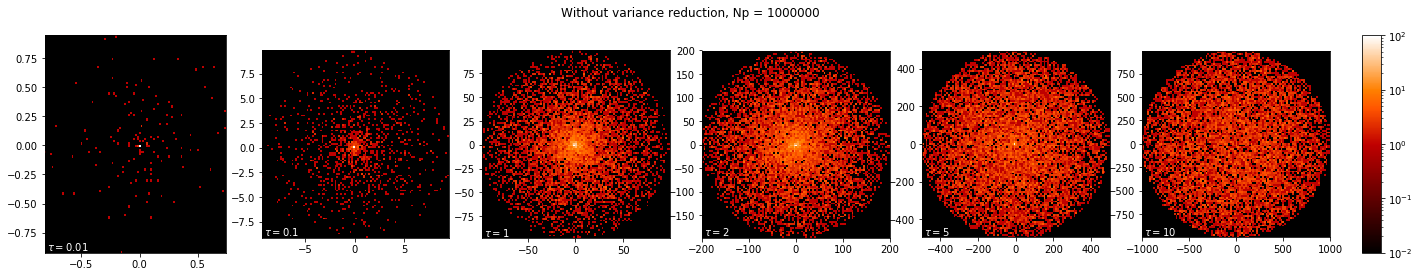

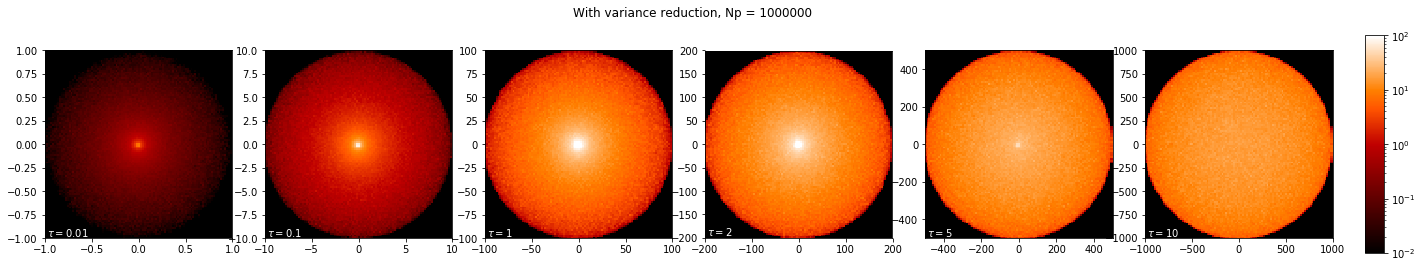

In [6]:
fig1 = plot_image(mcrt_objs)
fig2 = plot_image(mcrt_objs_nee)